In [1]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np

from IPython.core.debugger import Tracer

from keras.datasets import mnist

from keras.layers import Input, Dense,Add, Reshape, Flatten, Dropout, AveragePooling2D
from keras.layers import BatchNormalization, Conv2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, RMSprop, SGD

import matplotlib.pyplot as plt
import random
import os
import cv2
from keras import backend as K 

import tensorflow as tf

Using TensorFlow backend.


## Load the dataset

In [2]:
resolution_max = 32
latent_dim =512

In [3]:
DATA_FOLDER = "./img_align_celeba/"

In [4]:
selection =random.sample(os.listdir(DATA_FOLDER), 10000)
X_train = [cv2.resize(cv2.imread(DATA_FOLDER+file),(resolution_max,resolution_max), interpolation = cv2.INTER_CUBIC) for file in selection]
X_train = np.array(X_train)
X_train = X_train / 127.5 - 1. 
X_train[0].shape

(32, 32, 3)

## Show some example from the dataset

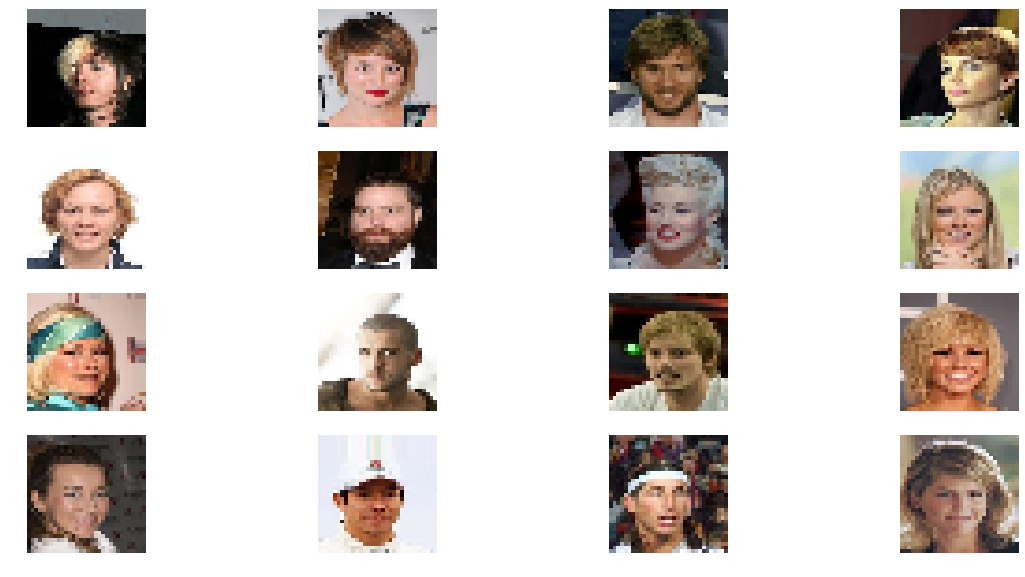

In [5]:
resize_factor = 0.5
r =4
c =4
fig, axs = plt.subplots(r, c, figsize=(20, 10))    
cnt = 0

for i in range(r):
    for j in range(c):
        img = X_train[cnt, :,:,:]
        img = (0.5+img*0.5)
        img = img[...,::-1]
        img = (img*255).astype("uint8")
        #img = cv2.resize(img,None,fx=2-resize_factor, fy=2-resize_factor, interpolation = cv2.INTER_CUBIC)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        cnt += 1

## The model

In [6]:
def generator(resolution, latent_dim):
    
    if resolution ==4:
        
        inp = Input(shape=(1,1, latent_dim), name="input_"+str(resolution))
        x = Reshape([4,4,512//16], name="reshape_"+str(resolution))(inp)
        
        x = Conv2D(512, (4, 4), padding='same', name="conv1_"+str(resolution))(x)
        x = LeakyReLU(alpha=0.2, name="relu1_"+str(resolution))(x)
        x = BatchNormalization(momentum=0.8, name="batch1_"+str(resolution))(x)
        x = Conv2D(512, (3, 3), padding='same', name="conv2_"+str(resolution))(x)
        x = LeakyReLU(alpha=0.2, name="relu2_"+str(resolution))(x)
        x = BatchNormalization(momentum=0.8, name="batch2_"+str(resolution))(x)  
        
        x = Conv2D(3, (1, 1), padding='same', name="output_"+str(resolution))(x)
        model = Model(inp, x)

    if resolution >= 8:
        first_layers = load_model("./models/ProGAN/"+str(resolution//2)+"_generator.hdf5")
        x = first_layers.layers[-2].output
        x = UpSampling2D(size = (2,2), interpolation = "nearest", name="upsampling_"+str(resolution))(x)
        
        x = Conv2D(512, (3, 3), padding='same', name="conv1_"+str(resolution))(x)
        x = LeakyReLU(alpha=0.2, name="relu1_"+str(resolution))(x)
        x = BatchNormalization(momentum=0.8, name="batch1_"+str(resolution))(x)
        x = Conv2D(512, (3, 3), padding='same', name="conv2_"+str(resolution))(x)
        x = LeakyReLU(alpha=0.2, name="relu2_"+str(resolution))(x)
        x = BatchNormalization(momentum=0.8, name="batch2_"+str(resolution))(x)
        
        x = Conv2D(3, (1, 1), padding='same', name="output_"+str(resolution))(x)
        
        model = Model(first_layers.layers[0].input, x)
    return model

In [7]:
def discriminator(resolution):
    if resolution ==4:
        img = Input(shape=(resolution,resolution,3), name="input_"+str(resolution))
        x = Conv2D(16, (1, 1), padding='same', name="conv1_"+str(resolution))(img)
        x = LeakyReLU(alpha=0.2, name="relu1_"+str(resolution))(x)
        x = Conv2D(32, (3, 3), padding='same', name="conv2_"+str(resolution))(x)
        x = LeakyReLU(alpha=0.2, name="relu2_"+str(resolution))(x)
        x = Conv2D(512, (3, 3), padding='same', name="conv3_"+str(resolution))(x)
        x = LeakyReLU(alpha=0.2, name="relu3_"+str(resolution))(x)
        x = Conv2D(512, (3, 3), padding='same', name="conv4_"+str(resolution))(x)
        x = LeakyReLU(alpha=0.2, name="relu4_"+str(resolution))(x)
        x = Conv2D(512, (4, 4), strides =4, padding='same', name="conv5_"+str(resolution))(x)
        x = LeakyReLU(alpha=0.2, name="relu5_"+str(resolution))(x)
        
        x = Reshape([512], name="reshape_"+str(resolution))(x)
        x = Dense(1, activation='sigmoid', name="dense_"+str(resolution))(x)

    if resolution >=8:
        img = Input(shape=(resolution,resolution,3), name="input_"+str(resolution))
        x = Conv2D(16, (1, 1), padding='same', name="conv1_"+str(resolution))(img)
        x = LeakyReLU(alpha=0.2, name="relu1_"+str(resolution))(x)
        x = Conv2D(32, (3, 3), padding='same', name="conv2_"+str(resolution))(x)
        x = LeakyReLU(alpha=0.2, name="relu2_"+str(resolution))(x)
        x = Conv2D(512, (3, 3), padding='same', name="conv3_"+str(resolution))(x)
        x = LeakyReLU(alpha=0.2, name="relu3_"+str(resolution))(x)
        x = Conv2D(512, (3, 3), padding='same', name="conv4_"+str(resolution))(x)
        x = LeakyReLU(alpha=0.2, name="relu4_"+str(resolution))(x)
        x = AveragePooling2D(pool_size=(2, 2), padding='same', name="pool_"+str(resolution))(x)
        
        last_layers = load_model("./models/ProGAN/"+str(resolution//2)+"_discriminator.hdf5")
        if resolution == 8 : keep = 6
        elif resolution == 16: keep =10
        elif resolution == 32: keep =14
        elif resolution == 64: keep =18
        else: keep=0
            
        for l in last_layers.layers[-keep:]:
            x = l(x)
            
    return Model(img, x)

In [8]:
def stacked_G_D(GG, DD):
    DD.trainable = False ## this freezes the weight, keep  
                        ## reading to understand why this is
                        ## necessary

    model = Sequential()
    model.add(GG)
    model.add(DD)
    return model

## Show and save samples during training

In [9]:
def sample_images(filename, epoch, generator, latent_dim, resize_factor):
    r, c = 4, 4
    noise = np.random.normal(0, 1, (r * c, 1,1, latent_dim))
    gen_imgs = G.predict(noise)
    
    fig, axs = plt.subplots(r, c, figsize=(20, 10))    
    cnt = 0
    
    for i in range(r):
        for j in range(c):
            img = gen_imgs[cnt, :,:,:]
            img = (0.5+img*0.5)
            img = img[...,::-1]
            img = (img*255).astype("uint8")
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig( "%s%d.png" % (filename,epoch))
    plt.close()

# TRAIN

In [10]:
latent_dim =512
#### pour resolution = 4
#OPTIMIZER_G = RMSprop(lr=1e-3)
#OPTIMIZER_D = Adam(lr=1e-3, beta_1 = 0.5, decay = 1e-9)
    
OPTIMIZER_G = Adam(lr=1e-4, beta_1 = 0,beta_2 = 0.99, decay = 1e-8)
OPTIMIZER_D = Adam(lr=1e-4, beta_1 = 0,beta_2 = 0.99, decay = 1e-8)

#res_list = [32]
#epoch_list=[50000]
res_list = [4, 8, 16, 32]
epoch_list=[5000, 10000, 50000, 50000]

for i in range(len(res_list)):
    sess = tf.Session()

    resolution = res_list[i]
    print("RESOLUTION ::: " + str(resolution))
    selection =random.sample(os.listdir(DATA_FOLDER), 10000)
    X_train = [cv2.resize(cv2.imread(DATA_FOLDER+file),(resolution,resolution), interpolation = cv2.INTER_CUBIC) for file in selection]
    X_train = np.array(X_train)
    X_train = X_train / 127.5 - 1. 
    
    G = generator(resolution,latent_dim)
    G.compile(loss='binary_crossentropy', optimizer=OPTIMIZER_G)
    D = discriminator(resolution)

    D.compile(loss='binary_crossentropy', optimizer=OPTIMIZER_D, metrics=['accuracy'] )

    G_D = stacked_G_D(G,D)
    G_D.compile(loss='binary_crossentropy', optimizer=OPTIMIZER_G)

    batch = 64
    epochs =epoch_list[i]
    #epochs=100
    FOLDER = "./results_ProGAN/results_res"+str(resolution)+"/"
    factor = 1

    flip = True
    for cnt in range(0, epochs):

        random_index =  np.random.randint(0, len(X_train) - batch//factor)
        legit_images = X_train[random_index : int(random_index + batch//factor)]#.reshape(int(batch/2), img_shape[0], img_shape[1], img_shape[2])

        gen_noise = np.random.normal(0, 1, (batch//factor,1,1,latent_dim))
        syntetic_images = G.predict(gen_noise)

        x_combined_batch = np.concatenate((legit_images, syntetic_images))

        z = np.random.random(batch//factor)/100
        o = 1-np.random.random(batch//factor)/100
        if flip:
            #y_combined_batch = np.concatenate((np.expand_dims(z,-1),np.expand_dims(o,-1)))
            y_combined_batch = np.concatenate((np.zeros((int(batch/factor), 1)), np.ones((int(batch/factor), 1))))
        else:
            #y_combined_batch = np.concatenate((np.expand_dims(o,-1),np.expand_dims(z,-1)))
            y_combined_batch = np.concatenate((np.ones((int(batch/factor), 1)), np.zeros((int(batch/factor), 1))))

        d_loss = D.train_on_batch(x_combined_batch, y_combined_batch)
        ## train generator

        noise = np.random.normal(0, 1, (batch,1,1,latent_dim))
        #y_mislabled = np.ones((batch, 1))

        if flip:
            y_mislabled = np.zeros((batch, 1))
            #y_mislabled = np.expand_dims(np.random.random(batch)/100, -1)
        else:
            #y_mislabled = np.expand_dims(1-np.random.random(batch)/100, -1)
            y_mislabled = np.ones((batch, 1))


        g_loss = G_D.train_on_batch(noise, y_mislabled)
        if cnt % 1000 == 0:
            print ("%d [D loss simple: %f, acc.: %.2f%%] [G loss: %f]" % (cnt, d_loss[0], 100*d_loss[1], g_loss))
            sample_images(FOLDER,cnt, G, latent_dim, 0.5)        
        #if cnt % 5000 == 0:
        #    flip = not flip
    G.save("./models/ProGAN/"+str(resolution)+"_generator.hdf5")
    D.save("./models/ProGAN/"+str(resolution)+"_discriminator.hdf5")
    G_D.save("./models/ProGAN/"+str(resolution)+"_combined.hdf5")

    G.save_weights("./models/ProGAN/"+str(resolution)+"_generator_weights.hdf5")
    D.save_weights("./models/ProGAN/"+str(resolution)+"_discriminator_weights.hdf5")
    G_D.save_weights("./models/ProGAN/"+str(resolution)+"_combined_weights.hdf5")
    del D
    del G
    del G_D
    #K.clear_session()
    #tf.reset_default_graph()
    sess.close()


Instructions for updating:
Colocations handled automatically by placer.
RESOLUTION ::: 32
Instructions for updating:
Use tf.cast instead.


/home/preiff/.virtualenvs/AI/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss simple: 1.405418, acc.: 50.00%] [G loss: 2.113177]
100 [D loss simple: 0.522789, acc.: 73.44%] [G loss: 2.302524]
200 [D loss simple: 0.366446, acc.: 86.72%] [G loss: 4.650691]


KeyboardInterrupt: 

In [ ]:
sess.close()

In [11]:
G.save("./models/ProGAN/"+str(resolution)+"_generator.hdf5")
D.save("./models/ProGAN/"+str(resolution)+"_discriminator.hdf5")
G_D.save("./models/ProGAN/"+str(resolution)+"_combined.hdf5")

G.save_weights("./models/ProGAN/"+str(resolution)+"_generator_weights.hdf5")
D.save_weights("./models/ProGAN/"+str(resolution)+"_discriminator_weights.hdf5")
G_D.save_weights("./models/ProGAN/"+str(resolution)+"_combined_weights.hdf5")

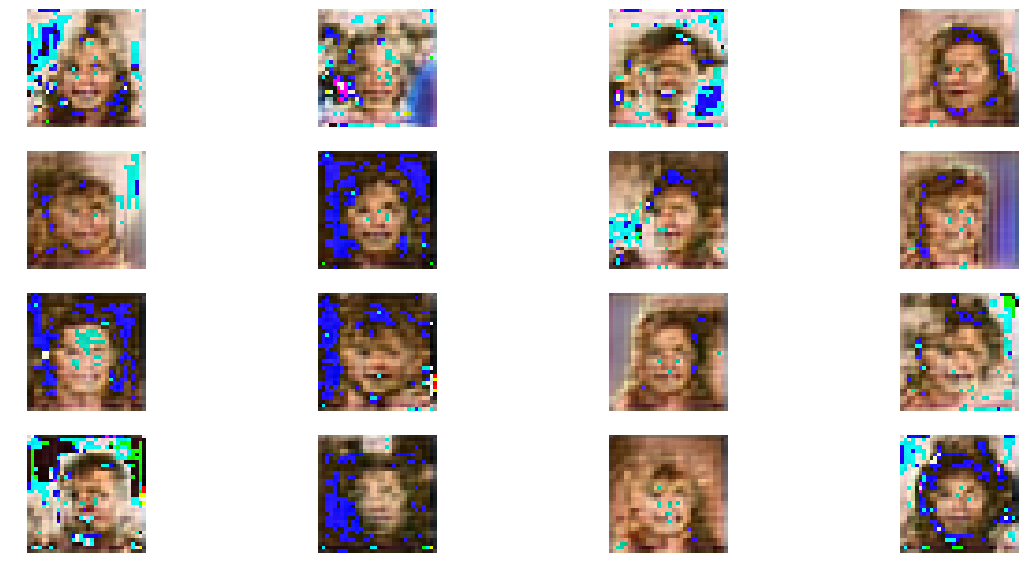

In [13]:
resize_factor = 0.5
r =4
c =4
fig, axs = plt.subplots(r, c, figsize=(20, 10))    
cnt = 0

gen_noise = np.random.normal(0, 1, (r*c,1,1,latent_dim))
gen_img = G.predict(gen_noise)

for i in range(r):
    for j in range(c):
        img = gen_img[cnt, :,:,:]
        img = (0.5+img*0.5)
        img = img[...,::-1]
        img = (img*255).astype("uint8")
        #img = cv2.resize(img,None,fx=2-resize_factor, fy=2-resize_factor, interpolation = cv2.INTER_CUBIC)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        cnt += 1